In [1]:
JSON_PATH = 'by-article-train_attn-data.json'

In [2]:
from json import JSONDecoder
data = JSONDecoder().decode(open(JSON_PATH).read())

In [3]:
word = 'Sponsored'
hyper_count = dict()
main_count = dict()

for i, article in enumerate(data):
    if word in article['normalizedText'][-1]:
        energies = [e for w, e in article['activations'][-1][0] if w == word]
        if article['hyperpartisan'] == 'true':
            hyper_count[i] = {
                'energies': energies,
                'truth': article['hyperpartisan'],
                'prediction': article['prediction'],
                'pred_value': article['pred_value'],
                'last_sent_e': article['activations'][-1][-1],
            }
        elif article['hyperpartisan'] == 'false':
            main_count[i] = {
                'energies': energies,
                'truth': article['hyperpartisan'],
                'prediction': article['prediction'],
                'pred_value': article['pred_value'],
                'last_sent_e': article['activations'][-1][-1],
            }
        else:
            raise RuntimeError('json format invalid')

In [4]:
# Average word energy of 1st 'Sponsored' tag
avg_final_e = [el['energies'][0] * el['last_sent_e'] for el in hyper_count.values()]
print('AVG:', sum(avg_final_e) / len(avg_final_e))
avg_final_e

AVG: 0.6635681491087156


[0.0354163683950901,
 0.992123124966998,
 0.9735337741791845,
 0.991712882118847,
 0.9944918046564446,
 0.6316286419148227,
 0.9086879082272752,
 1.803168602962205e-07,
 0.8397275080413777,
 0.9909074701408827,
 0.9974594270300798,
 0.9967450205754957,
 0.023736962833016406,
 0.07641113456554516,
 0.03000348564508537,
 0.8006365770388264,
 0.9974362642023351]

In [5]:
# Average final energy of 1st 'Sponsored' tag (word_e * sentence_e)
avg_final_e = [el['energies'][0] * el['last_sent_e'] for el in hyper_count.values()]
print('AVG:', sum(avg_final_e) / len(avg_final_e))
avg_final_e

AVG: 0.6635681491087156


[0.0354163683950901,
 0.992123124966998,
 0.9735337741791845,
 0.991712882118847,
 0.9944918046564446,
 0.6316286419148227,
 0.9086879082272752,
 1.803168602962205e-07,
 0.8397275080413777,
 0.9909074701408827,
 0.9974594270300798,
 0.9967450205754957,
 0.023736962833016406,
 0.07641113456554516,
 0.03000348564508537,
 0.8006365770388264,
 0.9974362642023351]

In [6]:
### ### ###

In [7]:
hyper_articles = [el for el in data if el['hyperpartisan'] == 'true']
main_articles = [el for el in data if el['hyperpartisan'] == 'false']
assert len(hyper_articles) + len(main_articles) == len(data)

In [8]:
hyper_sent_att = [activ[-1] for a in hyper_articles for activ in a['activations']]
main_sent_att = [activ[-1] for a in main_articles for activ in a['activations']]

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.distplot(hyper_sent_att, hist=False, rug=False, label="hyperpartisan")
sns.distplot(main_sent_att, hist=False, rug=False, label="mainstream")

plt.gcf().savefig('sentence_energy_distribution.png', dpi=400)

In [10]:
## Describe distribution
from scipy import stats
print('Hyperpartisan Sentence Energy distribution:')
print(stats.describe(hyper_sent_att), end='\n\n')

print('Mainstream Sentence Energy distribution:')
print(stats.describe(main_sent_att), end='\n\n')

Hyperpartisan Sentence Energy distribution:
DescribeResult(nobs=7519, minmax=(2.3341956058453867e-20, 0.9999939203262329), mean=0.03127569871829999, variance=0.018976125018488714, skewness=5.418113652206876, kurtosis=30.10368002392932)

Mainstream Sentence Energy distribution:
DescribeResult(nobs=7906, minmax=(1.918610192922653e-17, 0.9999979734420776), mean=0.05102500207225129, variance=0.03304226684127542, skewness=4.101548782503461, kurtosis=16.13745577230267)



In [11]:
## Average attention on most important sentence
hyper_most_imp_sent = [max(activ[-1] for activ in a['activations']) for a in hyper_articles]
main_most_imp_sent = [max(activ[-1] for activ in a['activations']) for a in main_articles]

In [12]:
print('Avg Hyperpartisan:', sum(hyper_most_imp_sent) / len(hyper_most_imp_sent))
print('Avg Mainstream:', sum(main_most_imp_sent) / len(main_most_imp_sent))

Avg Hyperpartisan: 0.7294364526930741
Avg Mainstream: 0.7810985228133729


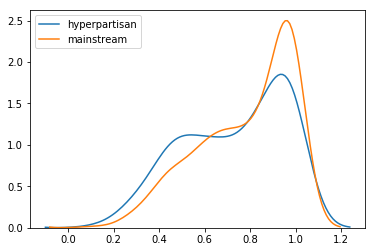

In [13]:
sns.distplot(hyper_most_imp_sent, hist=False, rug=False, label="hyperpartisan")
sns.distplot(main_most_imp_sent, hist=False, rug=False, label="mainstream")

plt.gcf().savefig('most_important_sentence_energy_distribution.png', dpi=400)

In [14]:
## Number of sentences with attention above a given threshold of importance
THRESHOLD = 0.3
hyper_important_sentences = [sum(1 for activ in a['activations'] if activ[-1] > THRESHOLD) for a in hyper_articles]
main_important_sentences = [sum(1 for activ in a['activations'] if activ[-1] > THRESHOLD) for a in main_articles]

In [15]:
print('Average number of sentences above {}:'.format(THRESHOLD))
print('\thyperpartisan: {}'.format(sum(hyper_important_sentences) / len(hyper_important_sentences)))
print('\tmainstream:    {}'.format(sum(main_important_sentences) / len(main_important_sentences)))

Average number of sentences above 0.3:
	hyperpartisan: 1.1265822784810127
	mainstream:    1.1105651105651106


In [16]:
### ### ###

In [17]:
## Calculating statistical significance that the two distributions are distinct
## Welch's t-test: https://en.wikipedia.org/wiki/Welch%27s_t-test
t_val, p_val = stats.ttest_ind(hyper_sent_att, main_sent_att, equal_var=False)
print('p-value for the hypothesis that the two distributions have equal mean:', p_val)

p-value for the hypothesis that the two distributions have equal mean: 2.529547738438885e-14


In [19]:
## Statistical significance of hypothesis:
## attention of most important sentence of a mainstream article is larger than that of a hyperpartisan article
from statsmodels.stats import weightstats as stests
_, p_val = stests.ztest(hyper_most_imp_sent, main_most_imp_sent, value=0)
print(p_val)

0.0028554798903885777
